### Import Packages

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import HuberLoss
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Load Historical Dataset

In [26]:
yield_weather_soil_df = pd.read_csv('historical_ywse_cleaned.csv')
df = yield_weather_soil_df

### Feature Selection

In [27]:
# Drop non-numeric columns
df_non_categorical = df.drop(['year', 'state', 'crop', 'season'], axis=1)

X = df_non_categorical.drop('yield', axis=1) # features
y = df_non_categorical['yield'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
selected_features = X.columns[lasso.coef_ != 0]
print("Selected features: ", selected_features)

Selected features:  Index(['Inflation annual %', 'Population', 'temperature_2m_min',
       'temperature_2m_max', 'precipitation_sum', 'Mean_N_SOIL', 'Mean_P_SOIL',
       'Mean_K_SOIL', 'Mean_TEMPERATURE', 'Mean_HUMIDITY'],
      dtype='object')


In [28]:
hist_df = df[['year', 'season', 'state', 'crop', 'yield','temperature_2m_min', 'temperature_2m_max', 'precipitation_sum',
       'Mean_N_SOIL', 'Mean_P_SOIL', 'Mean_K_SOIL', 'Mean_HUMIDITY', 'Mean_TEMPERATURE', 'Inflation annual %', 'Population']]

def map_season(season):
    return '04-30' if season == 'Summer' else ('08-31' if season == 'Autumn' else '12-31')

hist_df['Year_Season'] = hist_df.apply(lambda row: str(row['year']) + '-' + map_season(row['season']), axis=1)
hist_df = hist_df.sort_values('Year_Season')
hist_df['Year_Season'] = pd.to_datetime(hist_df['Year_Season'], format='mixed').dt.floor('D')
hist_df.reset_index(drop=True, inplace=True)
hist_df = hist_df.drop(columns=['year', 'season'])

In [29]:
# Aggregate data to be national-level by averaging values on state-level
agg_df = hist_df.groupby(['crop', 'Year_Season']).agg({
    'yield': 'sum',
    'temperature_2m_min':'mean',
    'temperature_2m_max':'mean',
    'precipitation_sum':'mean',
    'Mean_N_SOIL':'mean',
    'Mean_P_SOIL':'mean',
    'Mean_K_SOIL':'mean',
    'Mean_HUMIDITY':'mean',
    'Mean_TEMPERATURE':'mean',
    'Inflation annual %':'mean',
    'Population':'mean'
}).reset_index()

hist_df_nbx = agg_df.rename(columns={'Year_Season': 'ds', 'yield': 'y', 'crop': 'unique_id'})

### Load Forecast Dataset

In [30]:
futr_df = pd.read_csv('future_ywse_cleaned.csv')

columns = ['year','season', 'crop', 'yield', 'temperature_2m_min','temperature_2m_max','precipitation_sum',
            'Mean_N_SOIL','Mean_P_SOIL','Mean_K_SOIL', 'Mean_HUMIDITY', 'Mean_TEMPERATURE', 'Inflation annual %', 'Population']

numeric_cols = futr_df[columns]

futr_df = numeric_cols.groupby(['year', 'season', 'crop']).mean().reset_index()

# Drop the 'state' column if it exists
if 'state' in futr_df.columns:
    futr_df = futr_df.drop(columns=['state'])

In [31]:
futr_df['Year_Season'] = futr_df.apply(lambda row: str(row['year']) + '-' + map_season(row['season']), axis=1)
futr_df = futr_df.sort_values('Year_Season')
futr_df['Year_Season'] = pd.to_datetime(futr_df['Year_Season'], format='mixed').dt.floor('D')
futr_df.reset_index(drop=True, inplace=True)
futr_df = futr_df.drop(columns=['year', 'season'])

futr_df = futr_df.groupby(['crop', 'Year_Season']).agg({
    'yield':'mean',
    'temperature_2m_min':'mean',
    'temperature_2m_max':'mean',
    'precipitation_sum':'mean',
    'Mean_N_SOIL':'mean',
    'Mean_P_SOIL':'mean',
    'Mean_K_SOIL':'mean',
    'Mean_HUMIDITY':'mean',
    'Mean_TEMPERATURE':'mean',
    'Inflation annual %':'mean',
    'Population':'mean'
}).reset_index()
futr_df.head()

futr_df = futr_df.rename(columns={'Year_Season': 'ds', 'crop': 'unique_id', 'yield': 'y'})

### Concatenate Historical and Forecasted Dataset

In [32]:
# Merge template DataFrame with test data
comb_df = pd.concat([hist_df_nbx, futr_df], ignore_index=True)

# Ensure the columns are in the same order
comb_df = comb_df.reindex(columns=futr_df.columns)

### Train NBEATSx Model

In [33]:
train = comb_df.loc[comb_df['ds'] <= '2018-12-31']
valid = comb_df.loc[(comb_df['ds'] >= '2019-04-30') & (comb_df['ds'] <= '2028-12-31')]

horizon = valid['ds'].nunique()

In [34]:
# Import our modified version of NBEATSx which includes SelfAttention and ResidualConnection
from nbeatsx_SARC import NBEATSx
# Uncomment the line below if you want to use the original NBEATSx
# from neuralforecast.models import NBEATSx

models = [NBEATSx(h=horizon,input_size=26,
                  loss=HuberLoss(),
                  learning_rate=0.001,
                  dropout_prob_theta=0.5,
                  max_steps=100,
                  stack_types = ["identity", "trend", "seasonality", "exogenous"],
                  n_blocks = [1,1,1,1],
                  val_check_steps=10,
                  scaler_type='standard',
                  activation='ReLU'
                )]

Seed set to 1


In [35]:
nf = NeuralForecast(models=models, freq='4M')
nf.fit(df=train)

Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, v_num=1001, train_loss_step=1.030, train_loss_epoch=1.010]        

Epoch 49: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, v_num=1001, train_loss_step=0.486, train_loss_epoch=0.447]


### Model Evaluation (Train)

In [36]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

In [37]:
pred_insample = nf.predict_insample(step_size=horizon)
pred_insample = pred_insample[pred_insample['NBEATSx'] != -np.inf].reset_index()

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 222.18it/s]


In [38]:
joined_df_train = pd.merge(hist_df_nbx, pred_insample[['unique_id', 'ds', 'NBEATSx']], on=['unique_id', 'ds'])

evaluation_df_train = evaluate(joined_df_train.loc[:, joined_df_train.columns != 'cutoff'], metrics=[rmse])

columns_to_drop_train = evaluation_df_train.columns.difference(['unique_id', 'metric', 'NBEATSx'])

evaluation_df_train = evaluation_df_train.drop(columns=columns_to_drop_train)

In [39]:
rmse_val_train = evaluation_df_train['NBEATSx'].mean()
print("Average RMSE (Train): ", rmse_val_train)

Average RMSE (Train):  3.676695605507564


### Generate Predictions

In [40]:
pred_df = nf.predict(futr_df=valid).reset_index()
pred_df = pred_df.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 200.01it/s]


### Prepare DataFrame for Plotting

In [41]:
# Get unique values of 'unique_id' column
unique_ids = hist_df_nbx['unique_id'].unique()

# Comment out below section to see for graph all crops
filtered_ids = [id_ for id_ in unique_ids if 
              'Sugarcane' in id_ or 
              'Maize' in id_ or 
              'Rice' in id_]

### Plot Time Series Forecast (National-level)

#### Individual Graphs for Crops of Interest

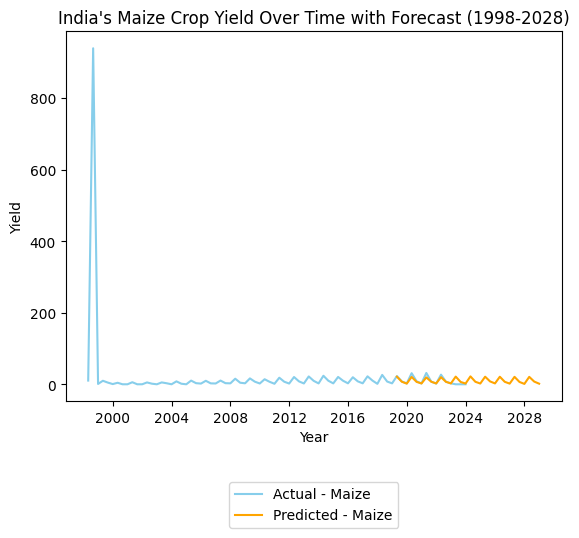

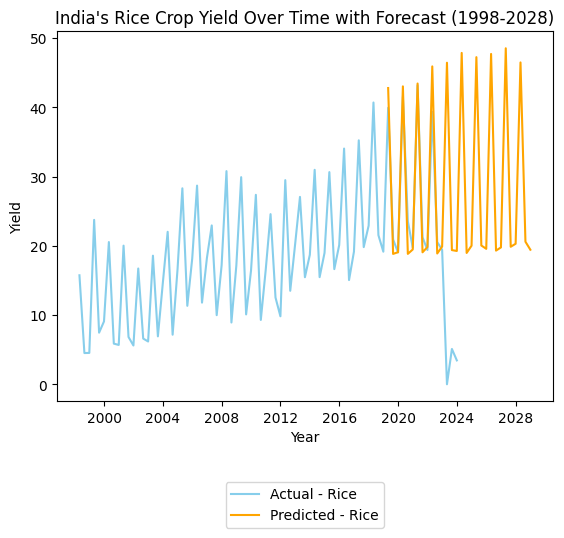

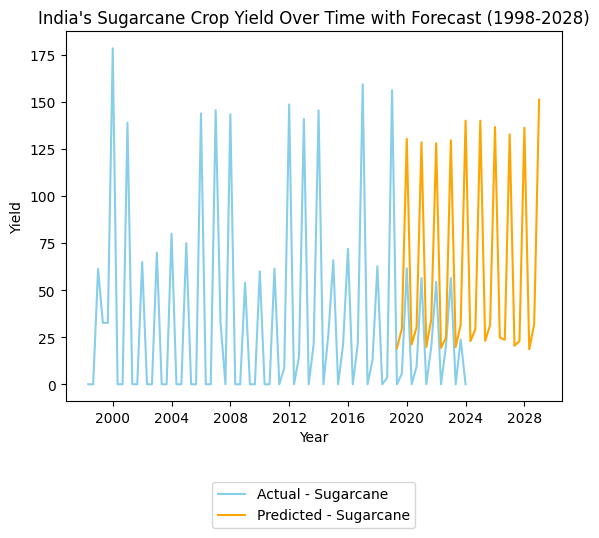

In [42]:
# Loop through each unique_id (crop)
for unique_id in filtered_ids:
    # Filter actual values for the current crop
    actual_values = hist_df_nbx[hist_df_nbx['unique_id'] == unique_id]
    
    # Filter predicted values for the current crop
    predicted_values = pred_df[pred_df['unique_id'] == unique_id]
    
    # Plot actual line graph
    plt.plot(actual_values['ds'], actual_values['y'], label=f'Actual - {unique_id}', color='skyblue')
    
    # Plot predicted line graph
    plt.plot(predicted_values['ds'], predicted_values['NBEATSx'], label=f'Predicted - {unique_id}', color='orange')
    
    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Yield')
    plt.title(f"India's {unique_id} Crop Yield Over Time with Forecast (1998-2028)")
    
    # Add legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    
    # Show plot
    plt.show()

#### Interactive Graph (All Crops)

In [43]:
# Initialize the figure
fig = go.Figure()

# Add actual lines
for unique_id in unique_ids:
    actual_values = hist_df_nbx[hist_df_nbx['unique_id'] == unique_id]
    fig.add_trace(go.Scatter(x=actual_values['ds'], y=actual_values['y'],
                             mode='lines',
                             name=f'Actual - {unique_id}',
                             line=dict(color='skyblue')))

# Add predicted lines
for unique_id in unique_ids:
    predicted_values = pred_df[pred_df['unique_id'] == unique_id]
    fig.add_trace(go.Scatter(x=predicted_values['ds'], y=predicted_values['NBEATSx'],
                             mode='lines',
                             name=f'Predicted - {unique_id}',
                             line=dict(color='orange')))

# Update layout
fig.update_layout(xaxis=dict(title='Year'),
                  yaxis=dict(title='Yield'),
                  title='India\'s Crop Yield Over Time with Forecast (1998-2030)',
                  showlegend=True)

# Add dropdown menu for selecting unique_id
buttons = []
for unique_id in unique_ids:
    button = dict(label=unique_id,
                  method="update",
                  args=[{"visible": [True if trace.name == f'Actual - {unique_id}' or 
                                     trace.name == f'Predicted - {unique_id}' else False for trace in fig.data]}])
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.0,
            xanchor='right',
            y=1.1,
            yanchor='top'
        )
    ])

# Show plot
fig.show()

### Model Evaluation

In [44]:
joined_df_test = pd.merge(hist_df_nbx, pred_df[['unique_id', 'ds', 'NBEATSx']], on=['unique_id', 'ds'])

In [45]:
evaluation_df_test = evaluate(joined_df_test.loc[:, joined_df_test.columns != 'cutoff'], metrics=[rmse])

columns_to_drop_test = evaluation_df_test.columns.difference(['unique_id', 'metric', 'NBEATSx'])

evaluation_df_test = evaluation_df_test.drop(columns=columns_to_drop_test)

In [46]:
rmse_val_test = evaluation_df_test['NBEATSx'].mean()
print("Average RMSE (Test): ", rmse_val_test)

Average RMSE (Test):  3.712600495406309


### Signal Decomposition

In [47]:
from neuralforecast.tsdataset import TimeSeriesDataset
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = train)
y_hat = model.decompose(dataset=dataset)

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.03it/s]


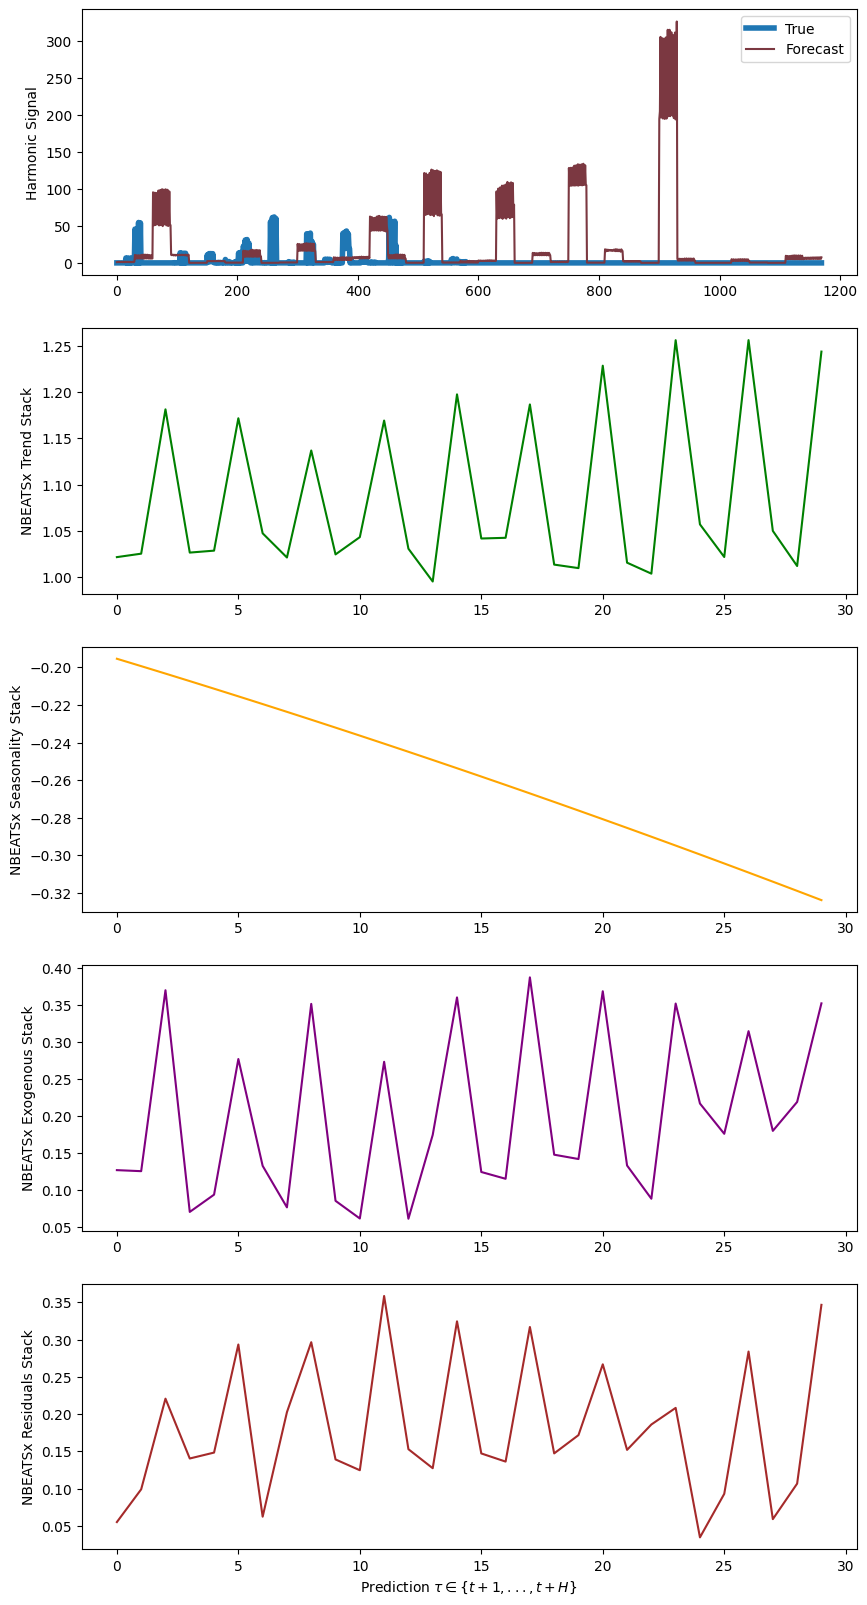

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 1, figsize=(10, 20))

ax[0].plot(valid['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NBEATSx Trend Stack')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NBEATSx Seasonality Stack')

ax[3].plot(y_hat[0,3], label='stack2', color="purple")
ax[3].set_ylabel('NBEATSx Exogenous Stack')

ax[4].plot(y_hat[0,4], label='stack2', color="brown")
ax[4].set_ylabel('NBEATSx Residuals Stack')

ax[4].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()